In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage import io
from scipy.signal import savgol_filter
import random
from joblib import load
import time
import helper_scripts
import unsupervised_scripts


## Sample Directory (different for everyone)
data_dir = (input('Enter the path to your .tif hyperstacks: ').strip() or os.getcwd())


## Load Image
from tkinter import*
root = Tk()
root.withdraw()
root.call('wm', 'attributes', '.', '-topmost', True)

from tkinter import filedialog
sample = filedialog.askopenfilename(initialdir=data_dir, multiple=True)
image = io.imread(sample[0])

indeces = [index for index, char in enumerate(sample[0]) if char=='/']
sample_name = sample[0][indeces[-1]+1:]

save_dir = 'D:/Shi_Lab/Spectral_Clustering/ML/output/'+sample_name+'/'
if os.path.exists(save_dir) == False:
  os.mkdir(save_dir)



## Vectorize Image
image_vec = np.reshape(image, (image.shape[0], image.shape[1]*image.shape[2]))
image_vec = image_vec.T

## Remove NaNs and inf
image[np.isinf(image)] = 0
image[np.isnan(image)] = 0

## Initialize start and end of hyperspectral sweep; num_samp is calculated from image stack
#wavenum_1 = int(input('Enter first wavenumber/higher wavelength (Default=2700)): ').strip() or '2700')
#wavenum_2 = int(input('Enter last wavenumber/lower wavelength (Default=3100): ').strip() or '3100')
wavenum_1 = 2700
wavenum_2 = 3100
num_samp = int(image_vec.shape[1])
ch_start = int(np.floor(num_samp/((wavenum_2-wavenum_1)/(2800-wavenum_1))))
background_df = pd.read_csv('water_HSI_76.csv')
molecule_df = pd.read_excel('lipid_subtype.xlsx')

### Semi-Supervised Learning

## Load artificial dataset
artificial_data = unsupervised_scripts.artificial_dataset(wavenum_1, wavenum_2, num_samp, ch_start, background_df)
[mol_norm, mol_names] = artificial_data.molecule_dataset(molecule_df)

X_data = np.load('artificial_data/artificial_training_data-'+str(wavenum_1)+'_'+str(wavenum_2)+'_'+str(num_samp)+'.npy')
Y_data = np.tile(np.array(range(mol_names.shape[0])), (X_data.shape[0], 1))
X = np.reshape(X_data, (X_data.shape[0] * X_data.shape[1], X_data.shape[2]))
Y = np.reshape(Y_data, (Y_data.shape[0] * Y_data.shape[1]))

## Process both datasets
preprocessing = unsupervised_scripts.preprocessing(wavenum_1, wavenum_2, num_samp, ch_start, background_df)
X_standard = preprocessing.spectral_standardization(np.flip(X,axis=1))
image_standard = preprocessing.spectral_standardization(np.flip(image_vec,axis=1))
image_max = np.max(np.percentile(image_standard,99,axis=0))
image_norm = helper_scripts.normalize_manual(image_standard, max_val=image_max, min_val=np.median(image_standard[:,:ch_start]))
image_norm = image_norm.T-np.median(image_norm[:,:ch_start],axis=1)
image_norm = image_norm.T
X_norm = helper_scripts.normalize(X_standard)#, max=np.mean([np.max(image_norm), np.percentile(image_norm, 99)]))
X_norm = X_norm.T-np.median(X_norm[:,:ch_start],axis=1)
X_norm = X_norm.T

Text(0, 0.5, 'Normalized Intensity (A.U.)')

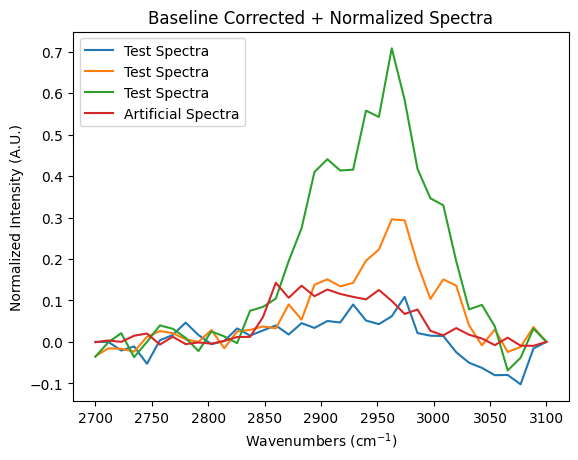

In [9]:
## Visualize random spectra for validation of preprocessing
wavenumbers = np.linspace(wavenum_1, wavenum_2, num_samp)
indeces = [random.randint(0,image_norm.shape[0]-1), random.randint(0,image_norm.shape[0]-1), random.randint(0,image_norm.shape[0]-1)]
plt.plot(wavenumbers, image_norm[indeces].T, label = 'Test Spectra')
plt.plot(wavenumbers, X_norm[np.random.randint(0,X_norm.shape[0])], label = 'Artificial Spectra')
plt.legend()
plt.title('Baseline Corrected + Normalized Spectra')
plt.xlabel('Wavenumbers (cm$^{-1}$)')
plt.ylabel('Normalized Intensity (A.U.)')

In [ ]:
## Optimize Smoothing of HSI and artificial spectra
w = int(input('Enter window size for Savitzky-Golay smoothing (Default=6): ').strip() or '6')
p = int(input('Enter polynomial for Savitzky-Golay smoothing (Default=3): ').strip() or '3')
preprocessing.sav_gol_optimization(image_norm, w, p)
preprocessing.sav_gol_optimization(X_norm, w, p)
x = savgol_filter(image_norm,w,p, axis=1, mode='mirror')
X = savgol_filter(X_norm,w,p, axis=1, mode='mirror')

In [3]:
## No smoothing (OPTIONAL)
x = image_norm
X = X_norm

Accuracy Score: 1.0


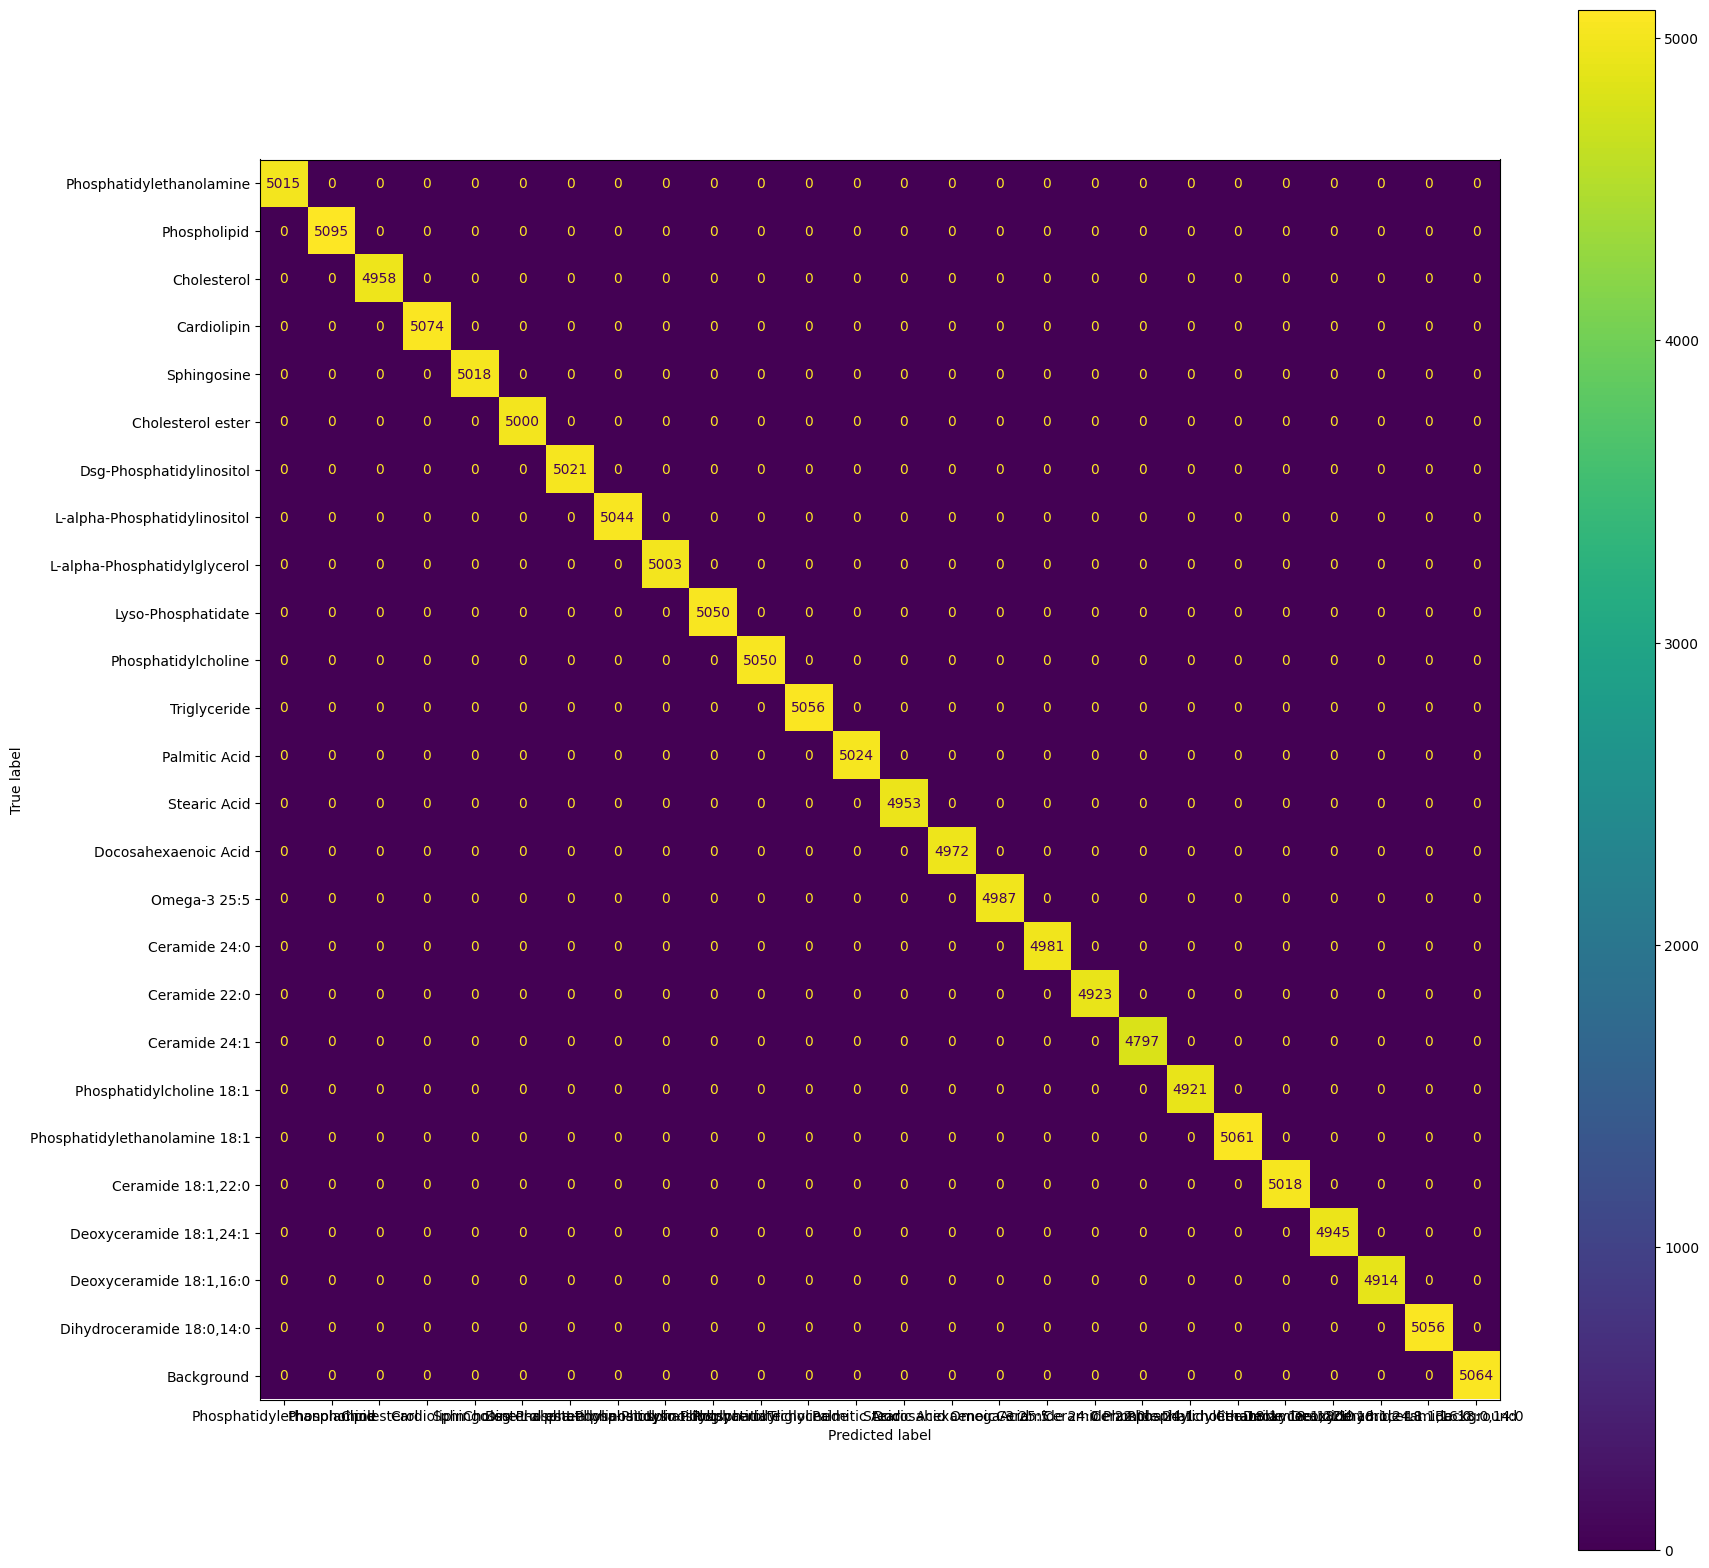

In [ ]:
## Random Forest Classification
rf_classifier = unsupervised_scripts.RF_classify(x, X, Y, .25)
rfc = load('rf_classifiers/rfc-'+str(wavenum_1)+'_'+str(wavenum_2)+'_'+str(num_samp)+'.joblib')
print('Accuracy Score: ' + str(rfc.score(rf_classifier.X_train, rf_classifier.y_train)))
rf_classifier.confusion_matrix(mol_names, rfc)

In [5]:
## USe Random Forest Classifier on Unlabeled HSI
start_time = time.time()
outputs = unsupervised_scripts.semi_supervised_outputs(x, mol_names, rfc)
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

Execution time: 969.8104345798492 seconds


Save spectral graphs?


 80%|████████  | 20/25 [00:07<00:01,  4.70it/s]d:\Shi_Lab\Spectral_Clustering\ML\unsupervised_scripts.py:364: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(10, 8))
100%|██████████| 25/25 [00:08<00:00,  3.00it/s]


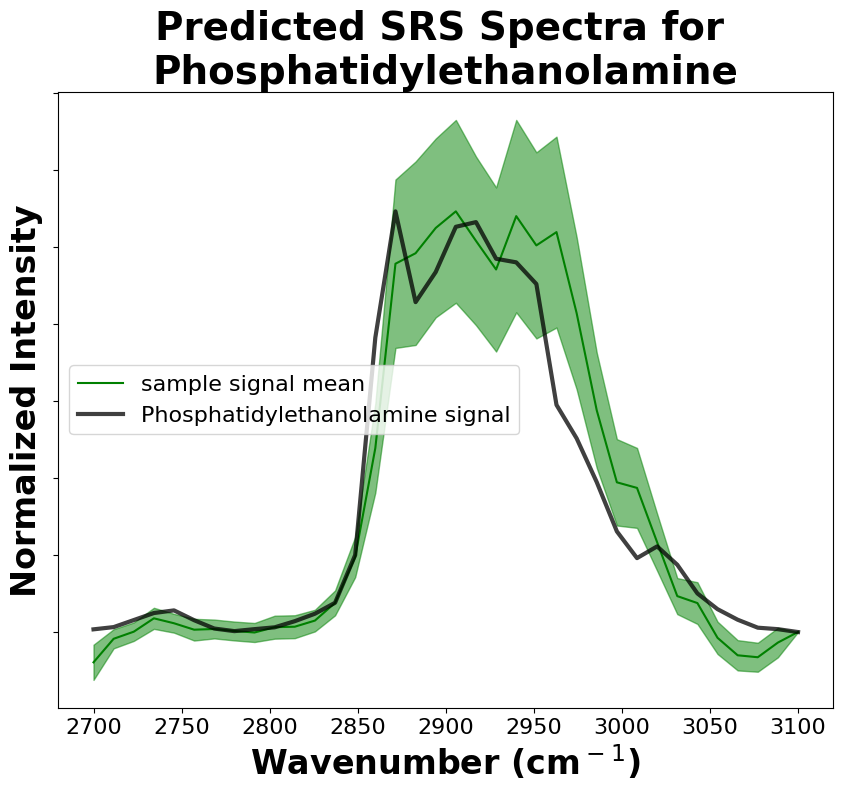

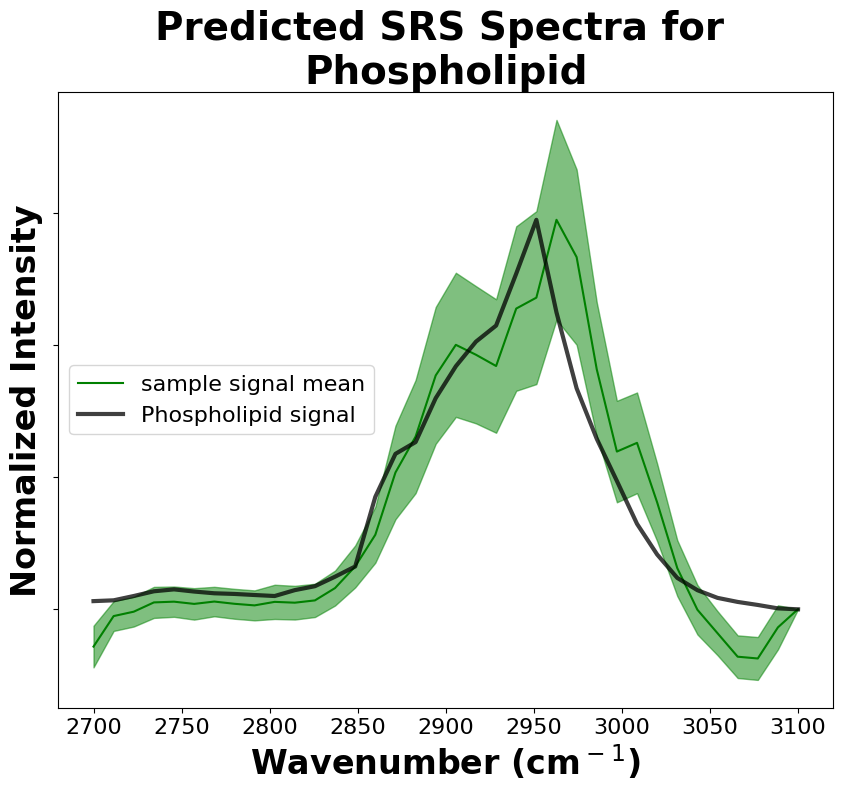

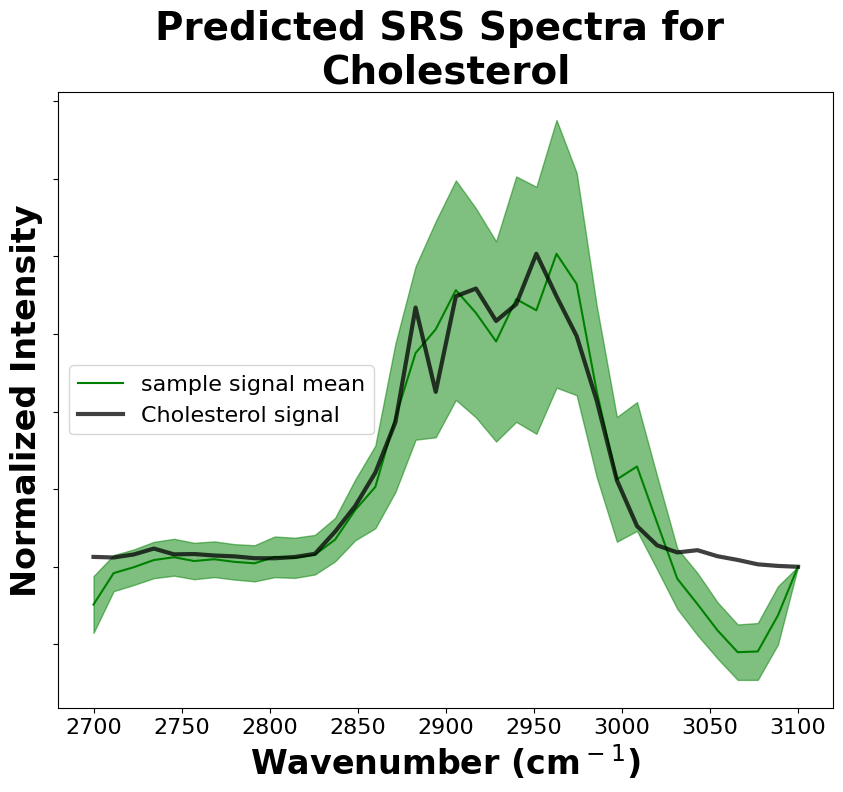

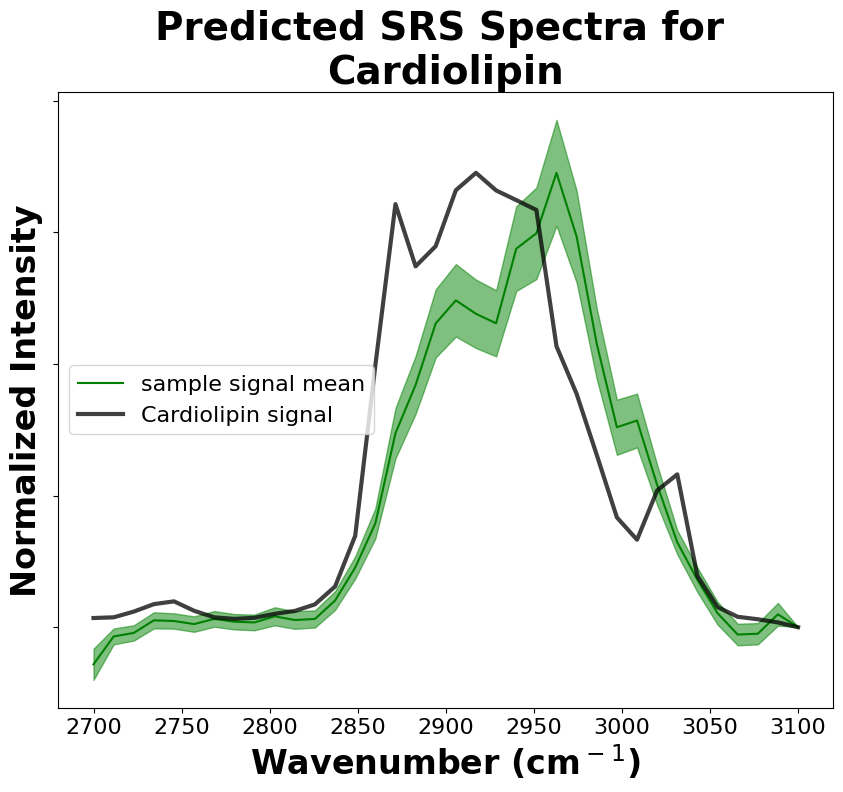

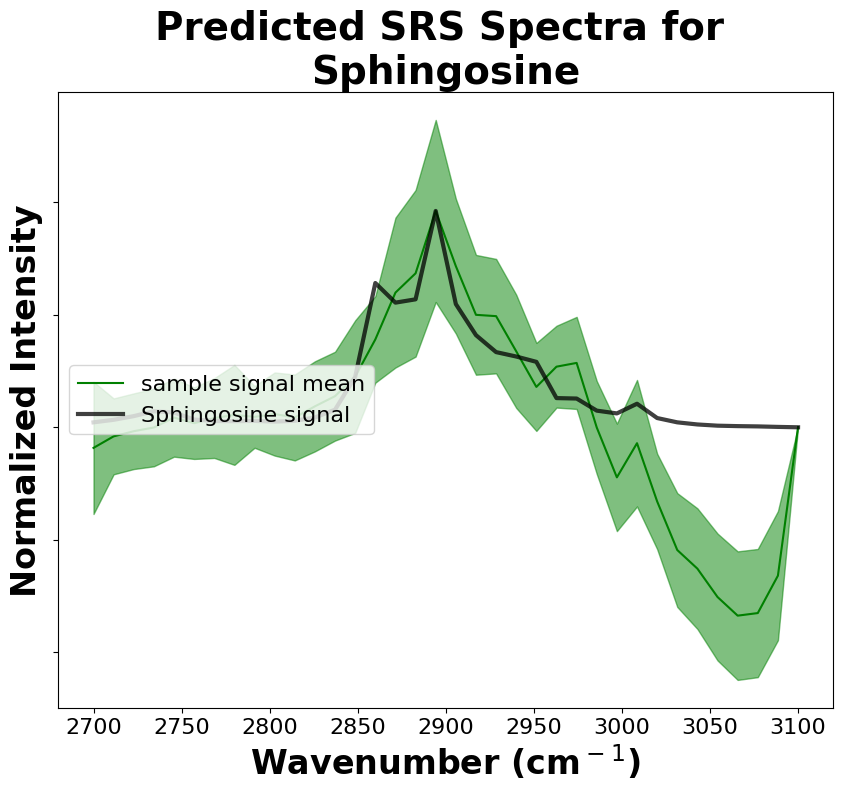

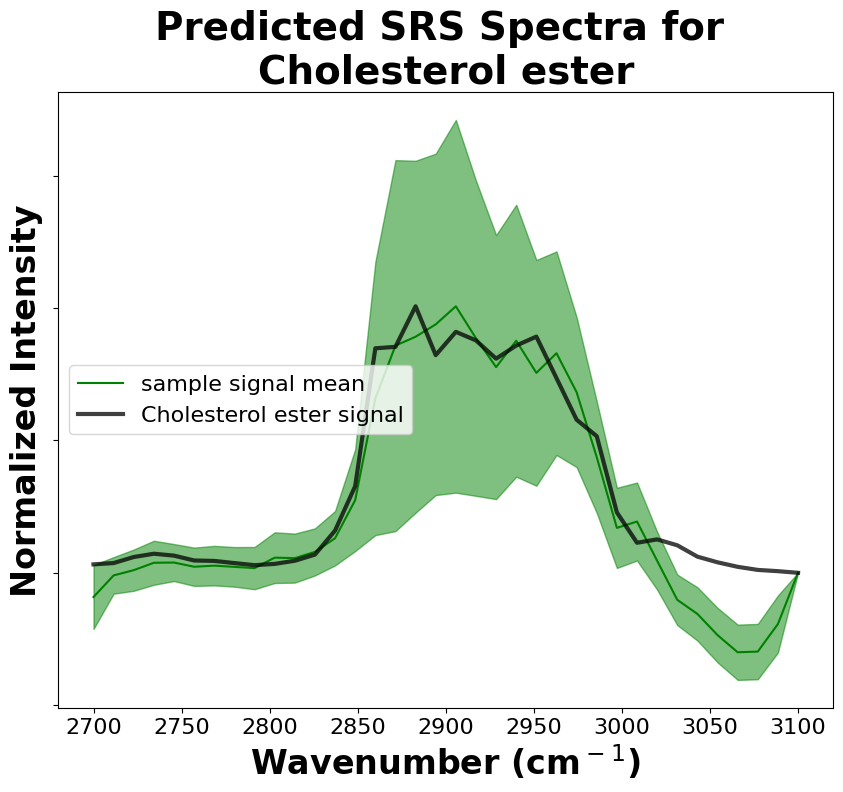

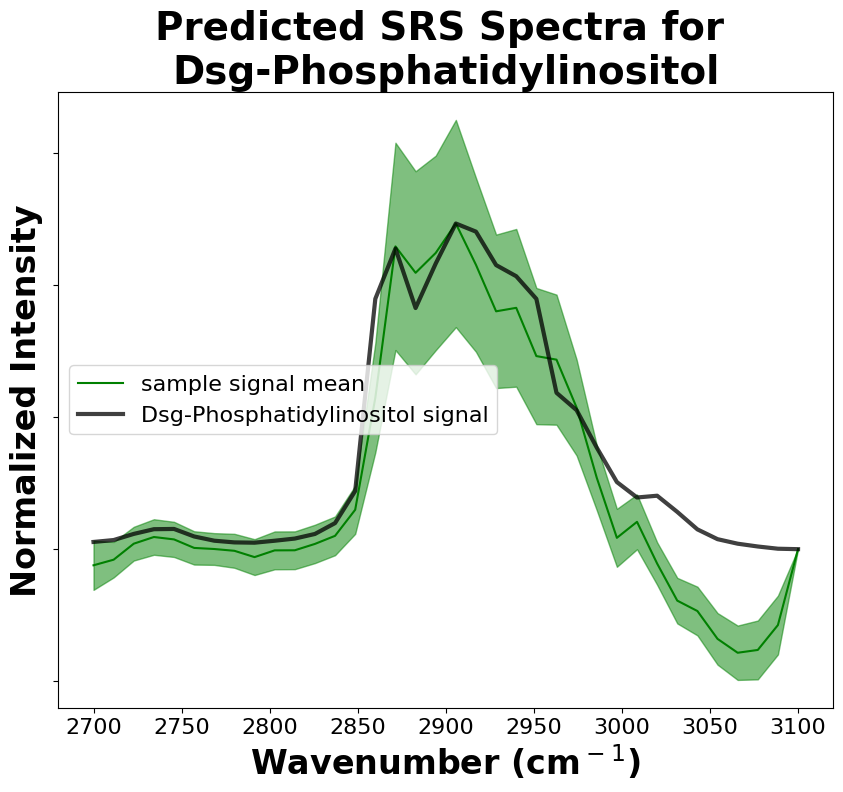

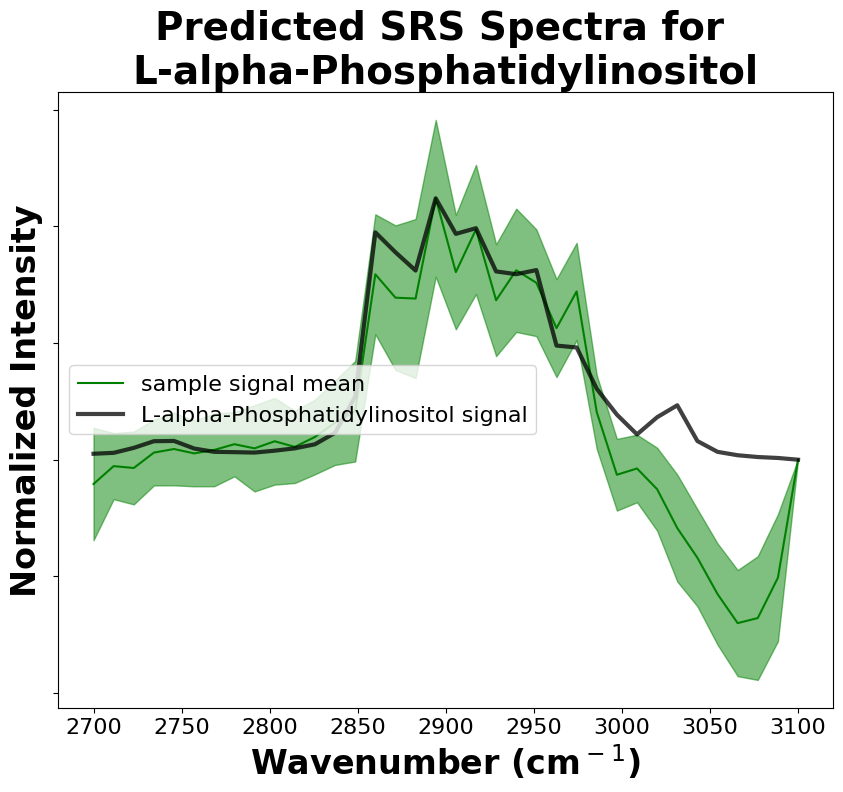

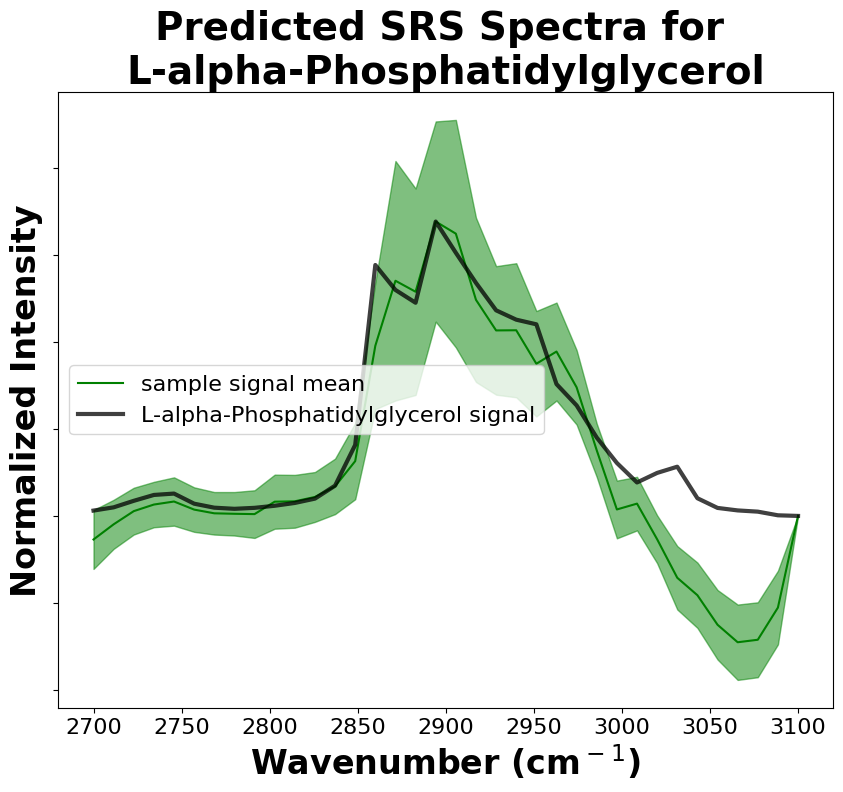

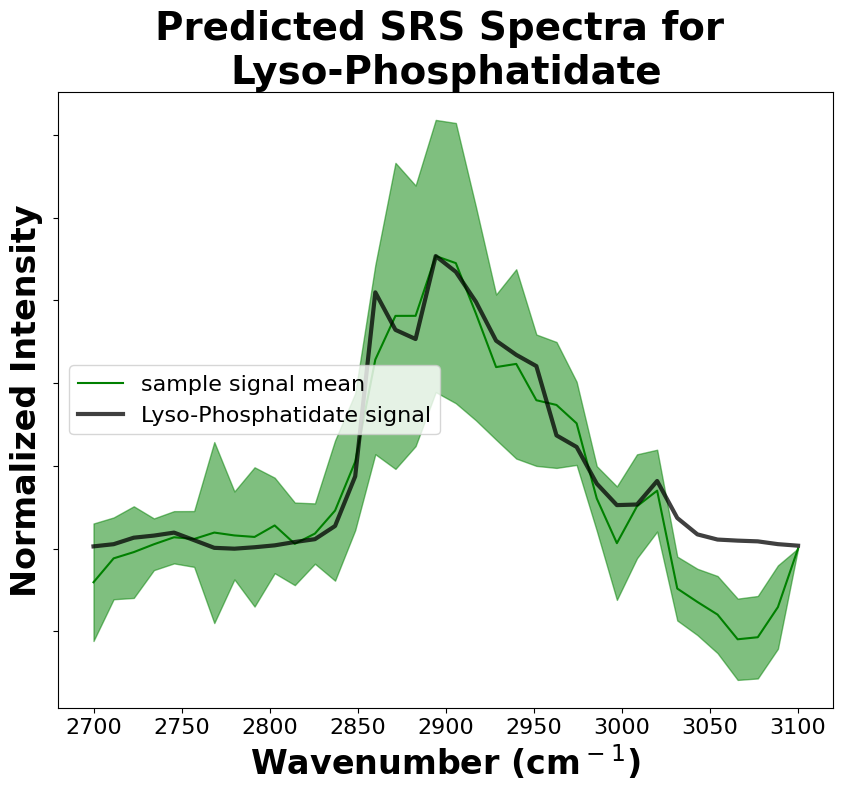

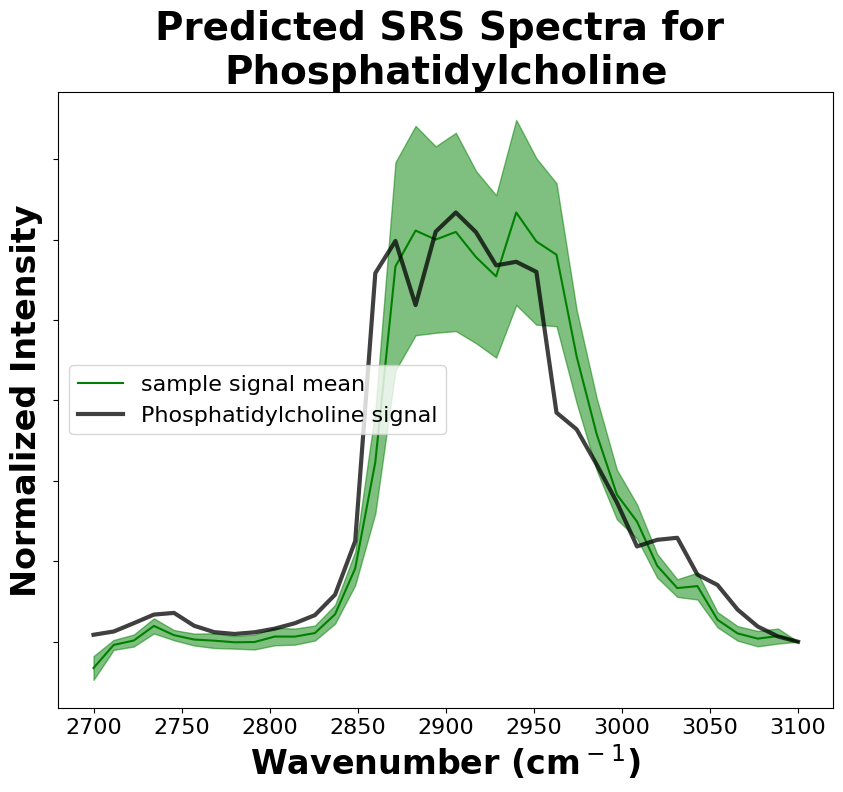

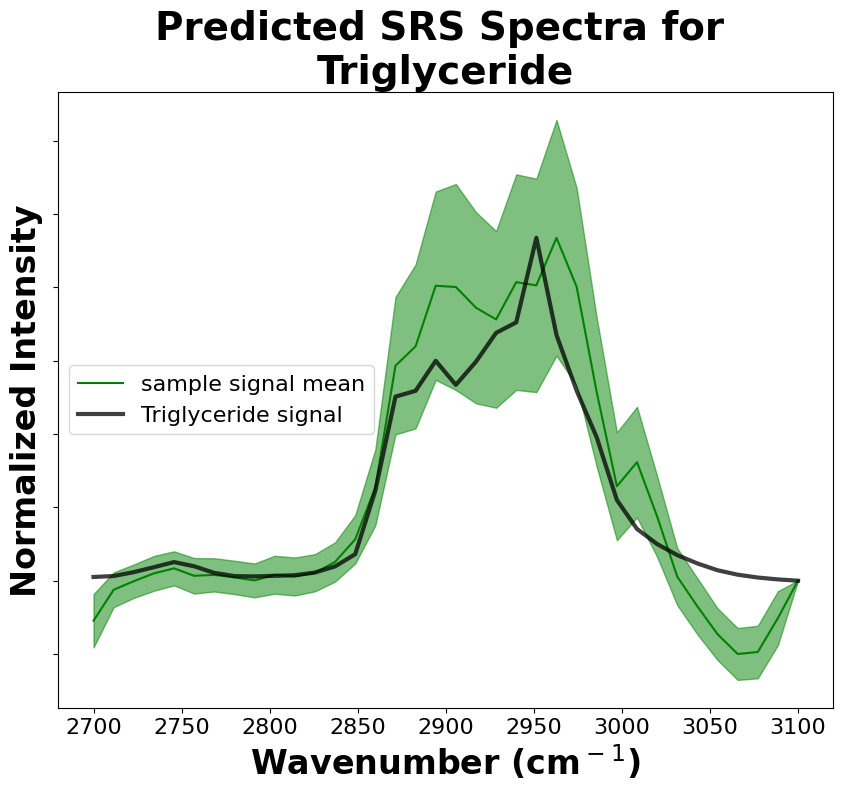

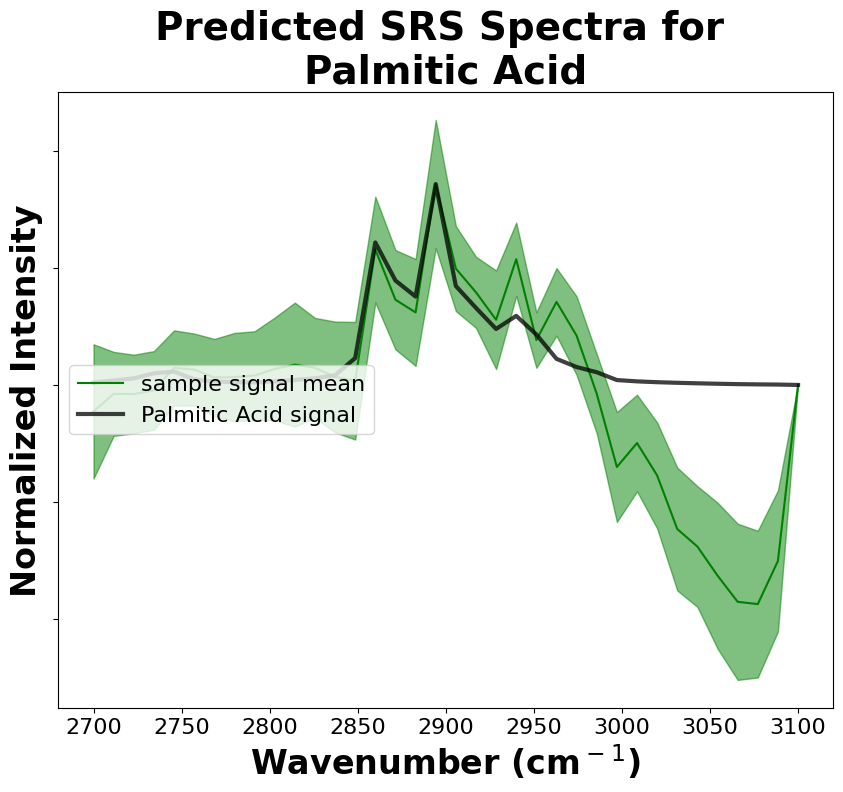

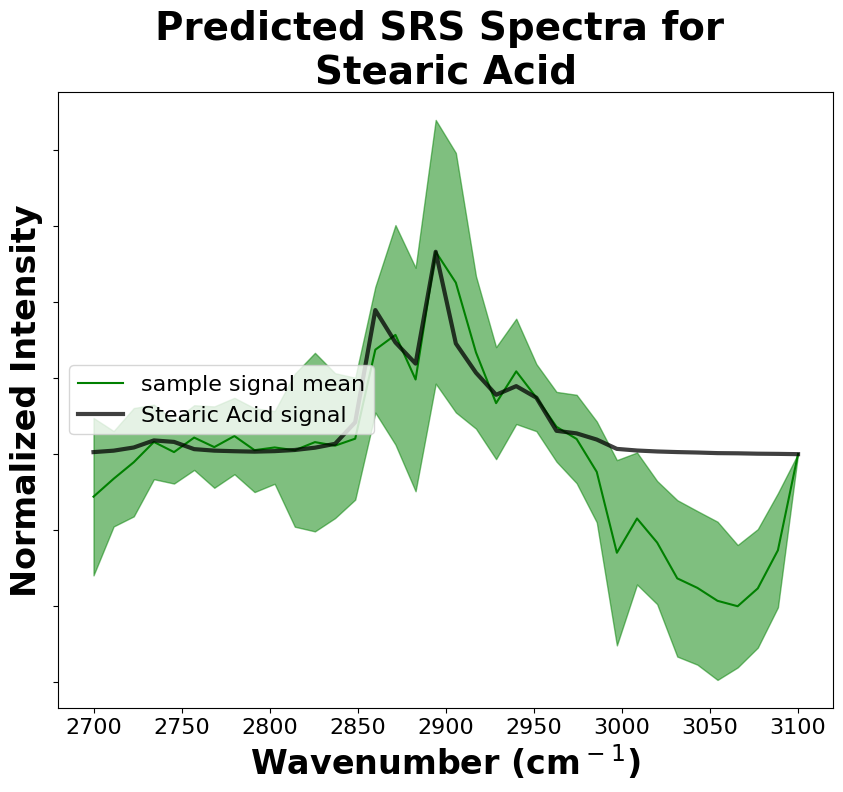

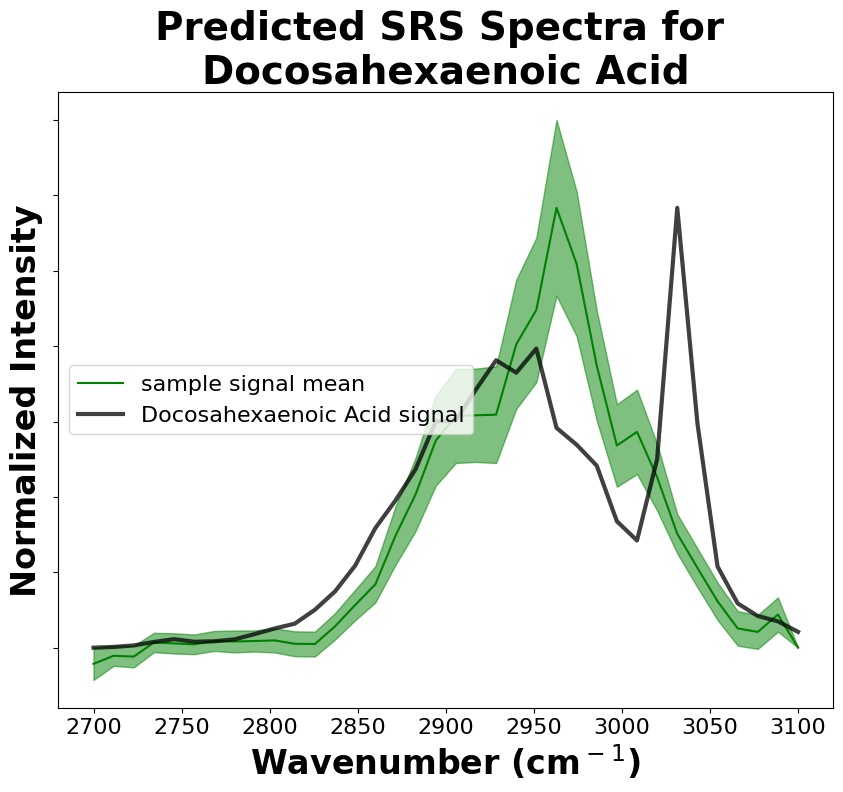

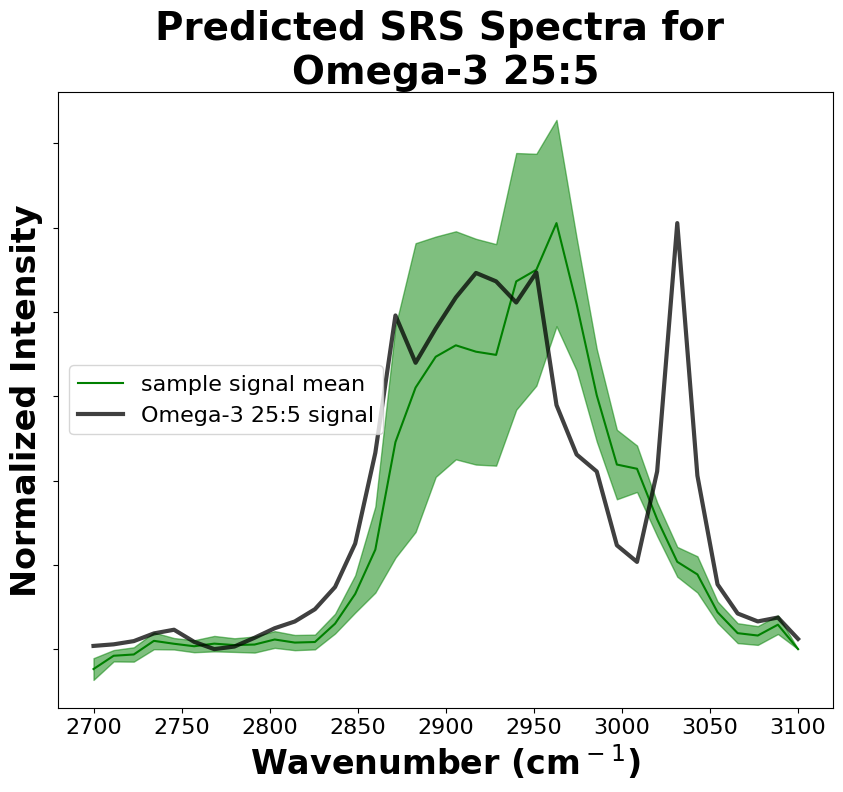

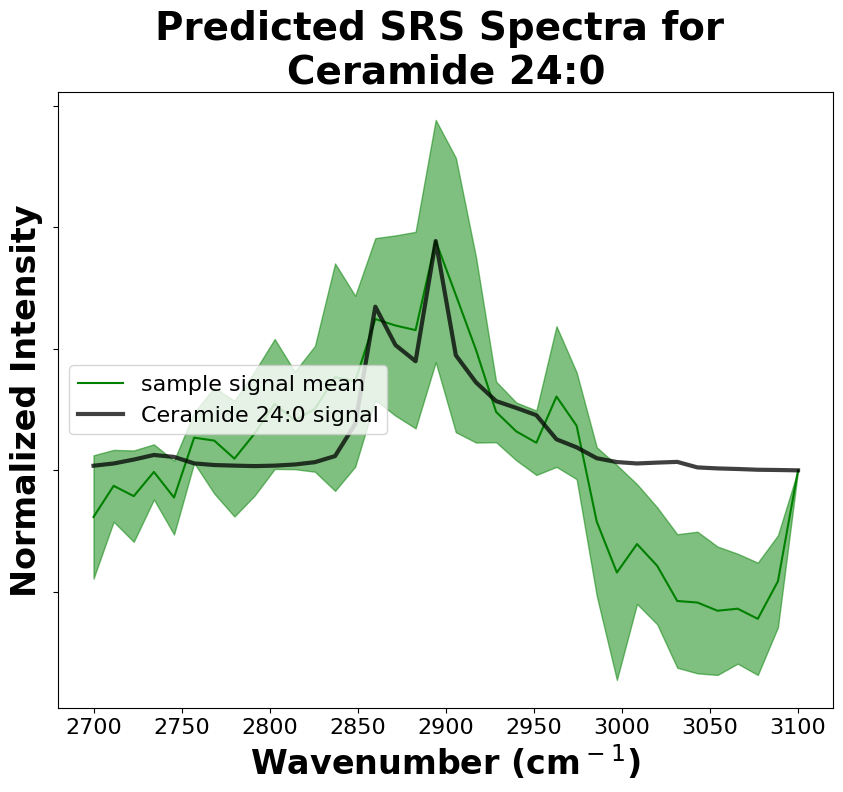

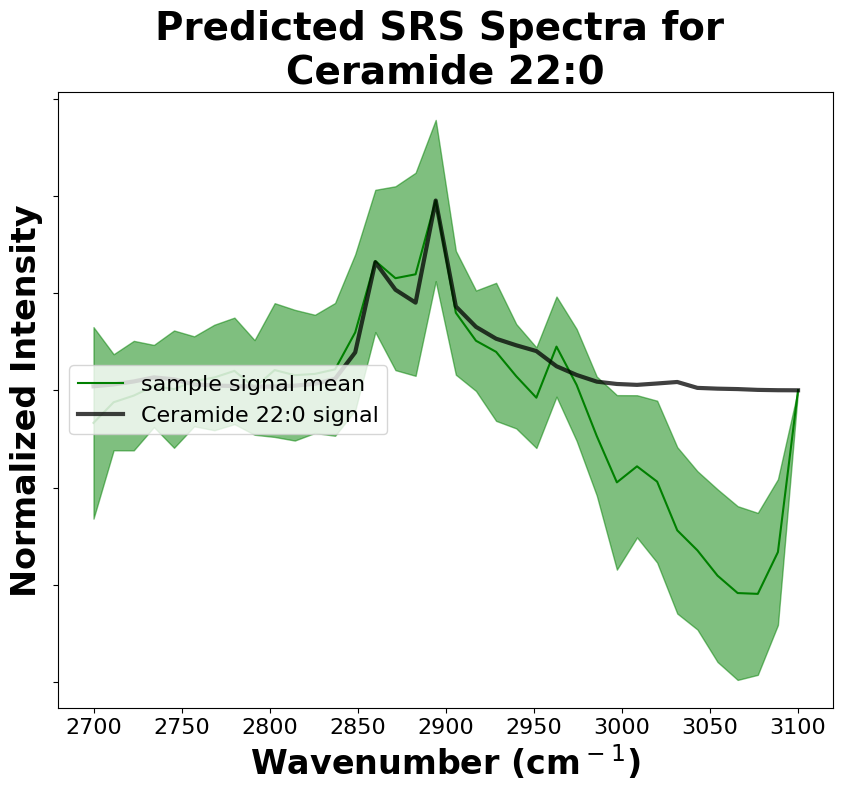

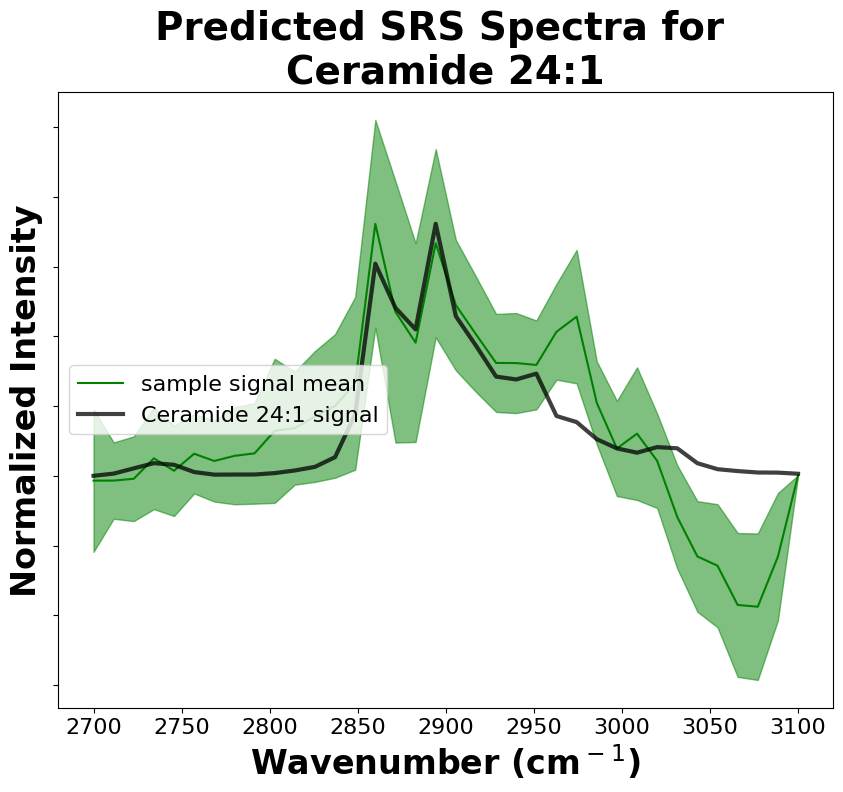

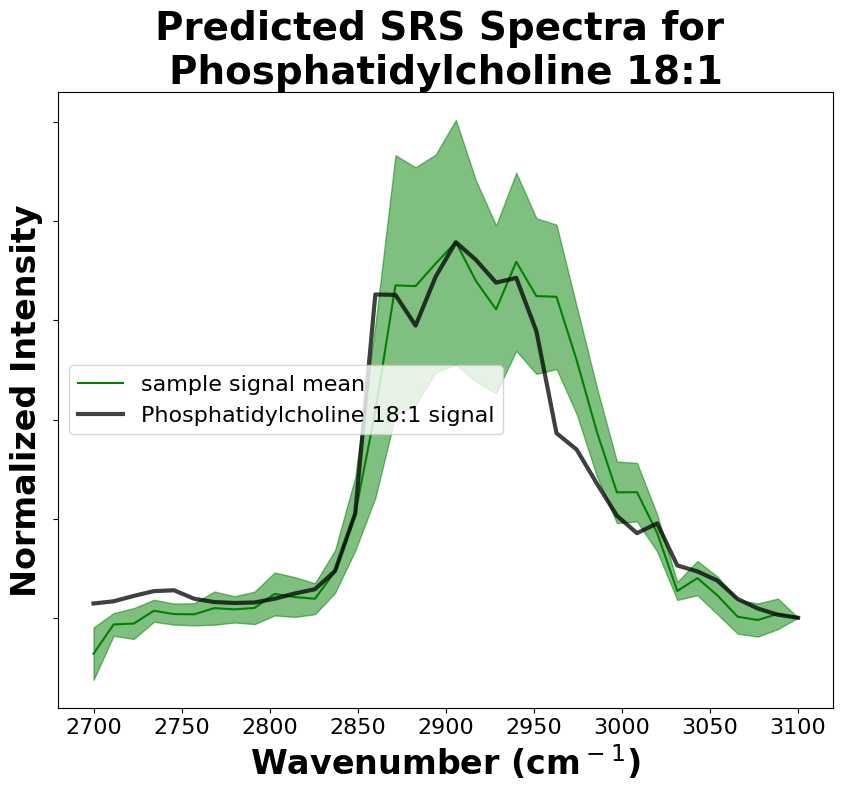

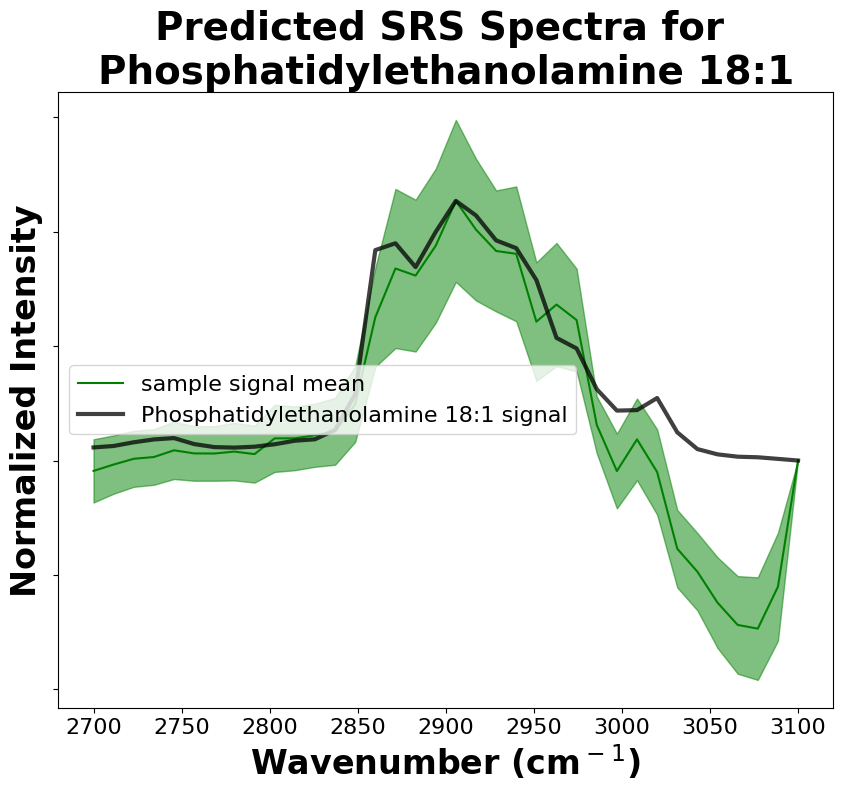

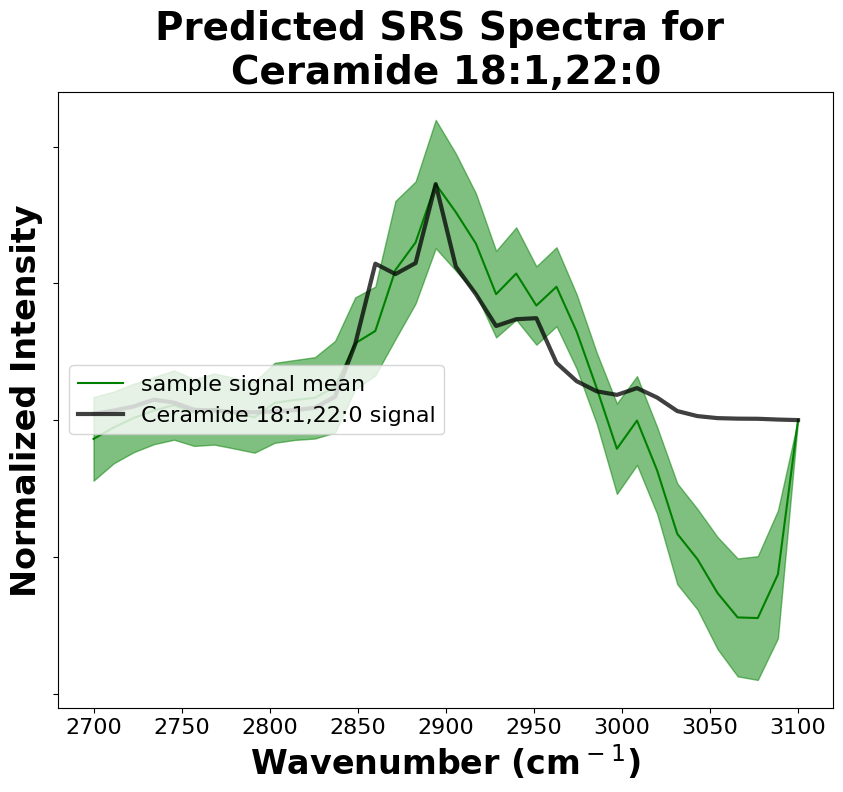

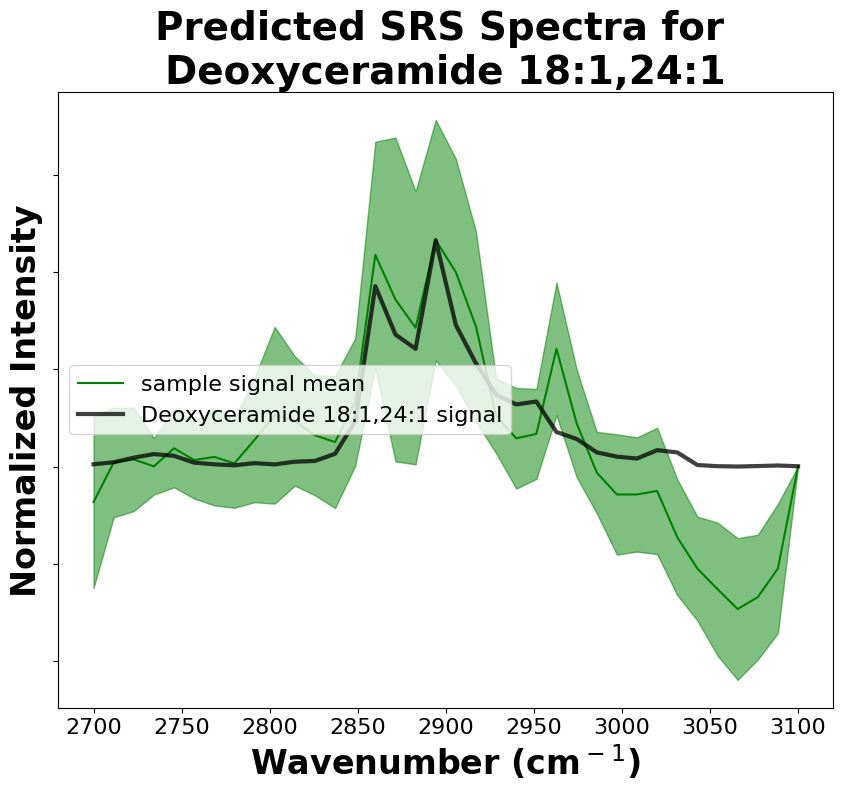

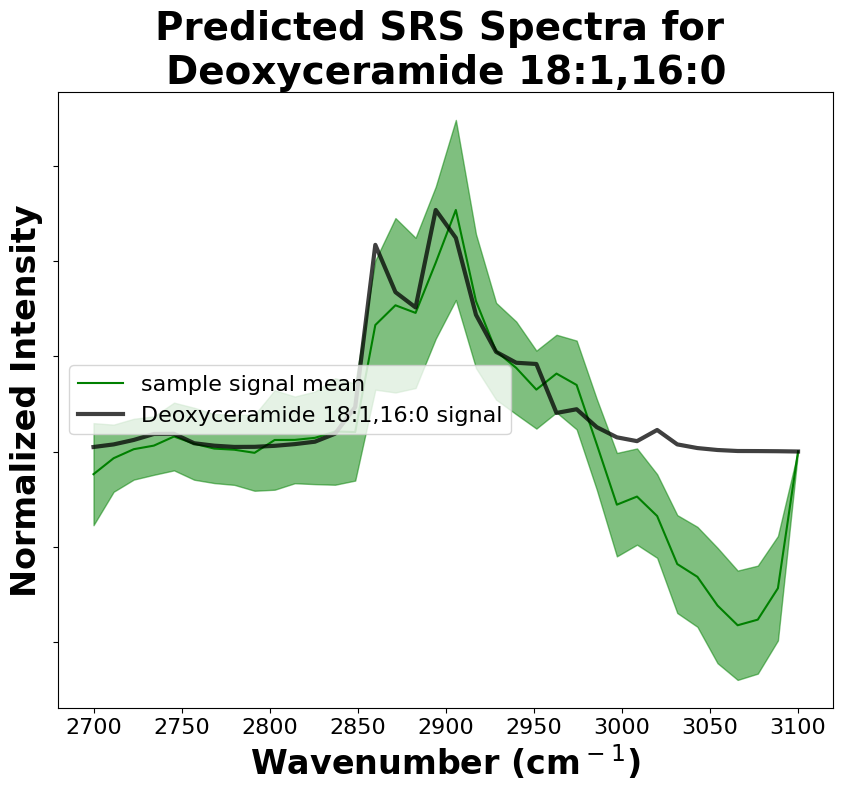

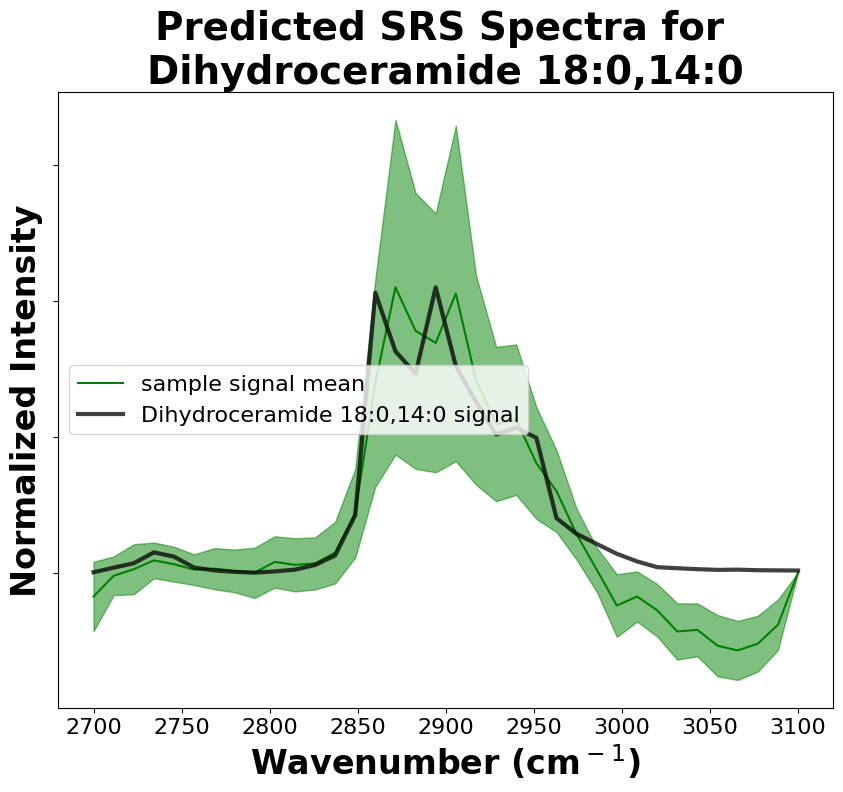

In [6]:
## Spectral Graphs
print('Save spectral graphs?')
#save_input = helper_scripts.save_input()
save_input=True
outputs.spectral_graphs(mol_norm, wavenumbers, save_input, save_dir)

In [7]:
print('Save probability images?')
#save_input = helper_scripts.save_input()
save_input=True
outputs.probability_images(image, save_input, save_dir)

Save probability images?


In [8]:
print('Save similarity metric .csv?')
#save_input = helper_scripts.save_input()
save_input=True
outputs.similarity_metrics(mol_norm, save_input, save_dir)

Save similarity metric .csv?


100%|██████████| 38270/38270 [00:08<00:00, 4388.47it/s]


The MSE for Phosphatidylethanolamine is: 0.11655142455933395
The Cosine Similarity for Phosphatidylethanolamine is: 0.9680390508179131
The Cross-Correlation for Phosphatidylethanolamine is: 0.9680508277316381


100%|██████████| 6935935/6935935 [26:12<00:00, 4410.16it/s]


The MSE for Phospholipid is: 0.007594416342783231
The Cosine Similarity for Phospholipid is: 0.753533948189077
The Cross-Correlation for Phospholipid is: 0.8011060823926502


100%|██████████| 1562352/1562352 [05:53<00:00, 4425.08it/s]


The MSE for Cholesterol is: 0.002598100219427818
The Cosine Similarity for Cholesterol is: 0.8197035205636913
The Cross-Correlation for Cholesterol is: 0.8364265816159515


100%|██████████| 1027064/1027064 [03:55<00:00, 4363.85it/s]


The MSE for Cardiolipin is: 0.009945912458959877
The Cosine Similarity for Cardiolipin is: 0.9537748919432829
The Cross-Correlation for Cardiolipin is: 0.9764659337982414


100%|██████████| 1920/1920 [00:00<00:00, 4116.28it/s]


The MSE for Sphingosine is: 0.004465716980274701
The Cosine Similarity for Sphingosine is: 0.8549667028958833
The Cross-Correlation for Sphingosine is: 0.8650541560603745


100%|██████████| 94947/94947 [00:21<00:00, 4434.04it/s]


The MSE for Cholesterol ester is: 0.004913475208733293
The Cosine Similarity for Cholesterol ester is: 0.7580130961765656
The Cross-Correlation for Cholesterol ester is: 0.7752730043099274


100%|██████████| 8231/8231 [00:01<00:00, 4406.83it/s]


The MSE for Dsg-Phosphatidylinositol is: 0.004025728222280884
The Cosine Similarity for Dsg-Phosphatidylinositol is: 0.9728456755937787
The Cross-Correlation for Dsg-Phosphatidylinositol is: 0.9728456755937788


100%|██████████| 714/714 [00:00<00:00, 4416.14it/s]


The MSE for L-alpha-Phosphatidylinositol is: 0.0015620946671399318
The Cosine Similarity for L-alpha-Phosphatidylinositol is: 0.6255803712543722
The Cross-Correlation for L-alpha-Phosphatidylinositol is: 0.6611417335118775


100%|██████████| 4497/4497 [00:01<00:00, 4429.75it/s]


The MSE for L-alpha-Phosphatidylglycerol is: 0.004795205237599538
The Cosine Similarity for L-alpha-Phosphatidylglycerol is: 0.8265719557692693
The Cross-Correlation for L-alpha-Phosphatidylglycerol is: 0.8625171422417419


100%|██████████| 424/424 [00:00<00:00, 4078.79it/s]


The MSE for Lyso-Phosphatidate is: 0.0010559358467989472
The Cosine Similarity for Lyso-Phosphatidate is: 0.9074821802512345
The Cross-Correlation for Lyso-Phosphatidate is: 0.9074821802512341


100%|██████████| 20611/20611 [00:04<00:00, 4398.86it/s]


The MSE for Phosphatidylcholine is: 0.03983754700637942
The Cosine Similarity for Phosphatidylcholine is: 0.9511293976824929
The Cross-Correlation for Phosphatidylcholine is: 0.9787778919301438


100%|██████████| 964457/964457 [03:38<00:00, 4423.78it/s]


The MSE for Triglyceride is: 0.003651752329936948
The Cosine Similarity for Triglyceride is: 0.9630763631341233
The Cross-Correlation for Triglyceride is: 0.9632423853478941


100%|██████████| 1388/1388 [00:00<00:00, 4419.98it/s]


The MSE for Palmitic Acid is: 0.0004237585359653442
The Cosine Similarity for Palmitic Acid is: 0.7478593738045471
The Cross-Correlation for Palmitic Acid is: 0.7478593738045469


100%|██████████| 218/218 [00:00<00:00, 4060.03it/s]


The MSE for Stearic Acid is: 0.0008334768232121313
The Cosine Similarity for Stearic Acid is: 0.6450672747886206
The Cross-Correlation for Stearic Acid is: 0.6450672747886205


100%|██████████| 99158/99158 [00:22<00:00, 4442.34it/s]


The MSE for Docosahexaenoic Acid is: 0.03173786042560974
The Cosine Similarity for Docosahexaenoic Acid is: 0.8249062048909751
The Cross-Correlation for Docosahexaenoic Acid is: 0.8448880892265548


100%|██████████| 90370/90370 [00:20<00:00, 4422.21it/s]


The MSE for Omega-3 25:5 is: 0.6586564812554394
The Cosine Similarity for Omega-3 25:5 is: 0.9169337017861661
The Cross-Correlation for Omega-3 25:5 is: 0.9193418854529449


100%|██████████| 38/38 [00:00<00:00, 4217.05it/s]


The MSE for Ceramide 24:0 is: 0.002364008770447233
The Cosine Similarity for Ceramide 24:0 is: 0.5793581881459451
The Cross-Correlation for Ceramide 24:0 is: 0.6475665832744385


100%|██████████| 2090/2090 [00:00<00:00, 4495.85it/s]


The MSE for Ceramide 22:0 is: 0.00213798160630018
The Cosine Similarity for Ceramide 22:0 is: 0.8152701891559413
The Cross-Correlation for Ceramide 22:0 is: 0.8152701891559413


100%|██████████| 1274/1274 [00:00<00:00, 4519.09it/s]


The MSE for Ceramide 24:1 is: 0.0009316258898701906
The Cosine Similarity for Ceramide 24:1 is: 0.7417130345446415
The Cross-Correlation for Ceramide 24:1 is: 0.7417130345446418


100%|██████████| 1402/1402 [00:00<00:00, 4452.61it/s]


The MSE for Phosphatidylcholine 18:1 is: 0.11040023519235213
The Cosine Similarity for Phosphatidylcholine 18:1 is: 0.6785517359608646
The Cross-Correlation for Phosphatidylcholine 18:1 is: 0.6785517359608647


100%|██████████| 15543/15543 [00:03<00:00, 4450.57it/s]


The MSE for Phosphatidylethanolamine 18:1 is: 0.007320945321604659
The Cosine Similarity for Phosphatidylethanolamine 18:1 is: 0.7768288469172251
The Cross-Correlation for Phosphatidylethanolamine 18:1 is: 0.7948481544148184


100%|██████████| 36012/36012 [00:08<00:00, 4423.28it/s]


The MSE for Ceramide 18:1,22:0 is: 0.0015698990365486624
The Cosine Similarity for Ceramide 18:1,22:0 is: 0.51685152446727
The Cross-Correlation for Ceramide 18:1,22:0 is: 0.5168515244672701


100%|██████████| 174/174 [00:00<00:00, 4516.40it/s]


The MSE for Deoxyceramide 18:1,24:1 is: 0.0013510132014918222
The Cosine Similarity for Deoxyceramide 18:1,24:1 is: 0.4706980539336756
The Cross-Correlation for Deoxyceramide 18:1,24:1 is: 0.4706980539336756


100%|██████████| 3209/3209 [00:00<00:00, 4478.71it/s]


The MSE for Deoxyceramide 18:1,16:0 is: 0.001055072663282956
The Cosine Similarity for Deoxyceramide 18:1,16:0 is: 0.6685551572019992
The Cross-Correlation for Deoxyceramide 18:1,16:0 is: 0.6685551572019991


100%|██████████| 1672/1672 [00:00<00:00, 4375.18it/s]


The MSE for Dihydroceramide 18:0,14:0 is: 0.018171768083565607
The Cosine Similarity for Dihydroceramide 18:0,14:0 is: 0.5941932496612895
The Cross-Correlation for Dihydroceramide 18:0,14:0 is: 0.5941932496612896


In [13]:
np.argsort(rfc.feature_importances_)

array([ 0,  5,  6, 35,  1,  7,  2,  8,  3, 34, 33,  9,  4, 11, 10, 32, 12,
       31, 27, 26, 30, 13, 19, 20, 16, 28, 21, 18, 15, 22, 25, 24, 23, 29,
       17, 14], dtype=int64)